In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import pathlib
import pandas as pd
import numpy as np
import tensorflow_datasets as tfds
import warnings
import datetime
from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
warnings.filterwarnings('ignore')

## **Download Stanford Dogs from tensorflow_datasets**

In [2]:
# Split train 90% validation 10% test 10%
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'stanford_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)


## **Metadata from tensorflow_datasets**

In [3]:
metadata

tfds.core.DatasetInfo(
    name='stanford_dogs',
    version=0.2.0,
    description='The Stanford Dogs dataset contains images of 120 breeds of dogs from around
the world. This dataset has been built using images and annotation from
ImageNet for the task of fine-grained image categorization. There are
20,580 images, out of which 12,000 are used for training and 8580 for
testing. Class labels and bounding box annotations are provided
for all the 12,000 images.',
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        }),
    }),
    total_num_examples=20580,
    splits={
        'test': 8580,
        'train': 12000,
    },
    supervised_keys=('image'

In [4]:
print("Number of Classes: {}".format(metadata.features['label'].num_classes))
print("First 5 Label names: {}".format([x.split("-")[1] for x in metadata.features['label'].names[:3]]))

Number of Classes: 120
First 5 Label names: ['chihuahua', 'japanese_spaniel', 'maltese_dog']


In [5]:
def resize_images(image, label):
    image = tf.image.resize(image, size=(250,250))
    #image = tf.cast(image, dtype = tf.float32)
    return image, label

In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.5)
])

# **Examples of the Data Augmentation**
#### First column are the original images

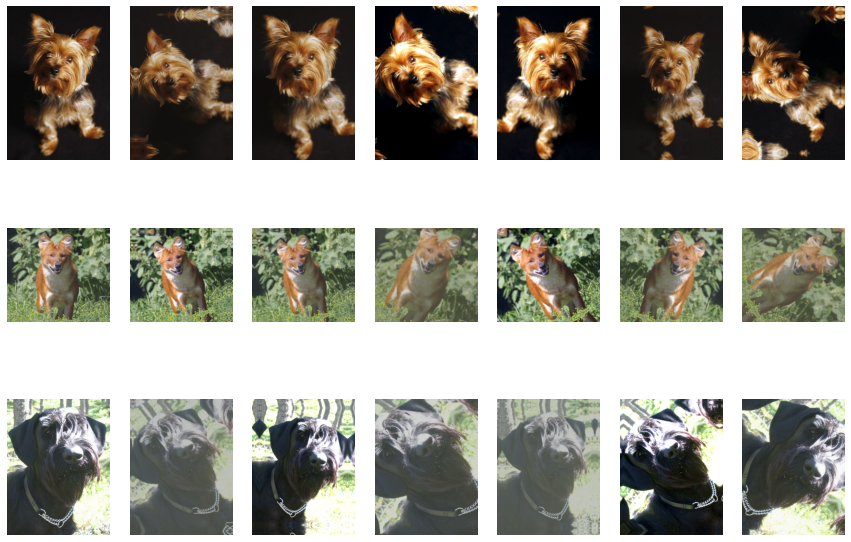

In [7]:
f, ax = plt.subplots(3, 7, figsize=(15,10))
for rowno, (img, label) in enumerate(train_ds.take(3)):
    ax[rowno, 0].imshow((img.numpy()))
    ax[rowno, 0].axis('off')
    for idx in range(1, 7):
        aug = data_augmentation(img/255, training=True)
        ax[rowno, idx].imshow(aug)
        ax[rowno, idx].axis('off')

In [8]:
def tf_model():

  inputs = tf.keras.Input(shape = (250, 250, 3))
  
  base_model = tf.keras.applications.DenseNet201(
      input_tensor = inputs,
      weights="imagenet",
      include_top=False
      )
  
  base_model.trainable = True
  
  for layer in base_model.layers[:-6]:
      layer.trainable = False

  x = data_augmentation(inputs)
  x = tf.keras.applications.densenet.preprocess_input(x)
  x = base_model(x)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(1024, activation="relu")(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(512, activation="relu")(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = tf.keras.layers.Dense(120, activation="softmax")(x)
  model = tf.keras.Model(inputs, outputs, name = 'densenet_model')

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss= tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics='accuracy')

  return model
model = tf_model()

In [9]:
model.summary()

Model: "densenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, 3)           0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 250, 250, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 250, 250, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 250, 250, 3)      0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)     

In [10]:
def process_pipeline(ds, shuffle = False):
  autotune = tf.data.AUTOTUNE
  ds = ds.map(map_func = resize_images, num_parallel_calls=autotune)
  ds = ds.cache()
  if shuffle:
    ds.shuffle(1000)
  return ds.batch(batch_size=128).prefetch(buffer_size = autotune)

In [11]:
train_ds = process_pipeline(train_ds, shuffle = True)
val_ds = process_pipeline(val_ds, shuffle = False)
test_ds = process_pipeline(test_ds, shuffle = False)

In [12]:
log_dir = "/content/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

callbacks_list = [
                 tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                                 patience=3, min_lr=0.00001
                                                 ),
                  
                 tf.keras.callbacks.ModelCheckpoint(
                    filepath = 'best_model.keras',
                    monitor = 'val_loss',
                    save_best_only = True
                ),

                tf.keras.callbacks.EarlyStopping(
                    monitor = 'val_accuracy',
                    patience = 7
                ),

                tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
]

In [13]:
history = model.fit(train_ds,
                    epochs=30,
                    validation_data = val_ds,
                    callbacks = callbacks_list
                    )

Epoch 1/30


75/75 [==============================] - ETA: 0s - loss: 2.8680 - accuracy: 0.3241WARNING:tensorflow:Model was constructed with shape (None, None, 3) for input KerasTensor(type_spec=TensorSpec(shape=(None, None, 3), dtype=tf.float32, name='random_flip_input'), name='random_flip_input', description="created by layer 'random_flip_input'"), but it was called on an input with incompatible shape (None, 250, 250, 3).


75/75 [==============================] - 204s 2s/step - loss: 2.8680 - accuracy: 0.3241 - val_loss: 0.8621 - val_accuracy: 0.7408 - lr: 0.0010
Epoch 2/30
75/75 [==============================] - 156s 2s/step - loss: 1.3538 - accuracy: 0.6014 - val_loss: 0.5876 - val_accuracy: 0.8042 - lr: 0.0010
Epoch 3/30
75/75 [==============================] - 156s 2s/step - loss: 1.1211 - accuracy: 0.6604 - val_loss: 0.5528 - val_accuracy: 0.8083 - lr: 0.0010
Epoch 4/30
75/75 [==============================] - 156s 2s/step - loss: 1.0170 - accuracy: 0.6920 - val_loss: 0.5117 - val_accuracy: 0.8250 - lr: 0.0010
Epoch 5/30
75/75 [==============================] - 156s 2s/step - loss: 0.9242 - accuracy: 0.7207 - val_loss: 0.4881 - val_accuracy: 0.8408 - lr: 0.0010
Epoch 6/30
75/75 [==============================] - 156s 2s/step - loss: 0.8817 - accuracy: 0.7325 - val_loss: 0.4637 - val_accuracy: 0.8400 - lr: 0.0010
Epoch 7/30
75/75 [==============================] - 156s 2s/step - loss: 0.8138 - accur

# **Evaluating model on unseen test data**

In [14]:
model.evaluate(test_ds)

10/10 [==============================] - 28s 3s/step - loss: 0.4854 - accuracy: 0.8550


[0.48540782928466797, 0.8550000190734863]

# **Predictions on single images**

In [26]:
def download_and_predict(url, filename):
    # download and save
    os.system("curl -s {} -o {}".format(url, filename))
    img = Image.open(filename)
    img = img.convert('RGB')
    img = img.resize((250, 250))
    img.save(filename)
    # show image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    # predict
    img = imread(filename)
    img = tf.keras.applications.densenet.preprocess_input(img)
    probs = model.predict(np.expand_dims(img, axis=0))
    y_classes = probs.argmax(axis=-1)

    class_names = metadata.features['label'].names
    class_dict = {}
    for id, classes in enumerate(class_names):
        class_dict[id] = classes
    return class_dict[y_classes[0]]

'n02108915-french_bulldog'

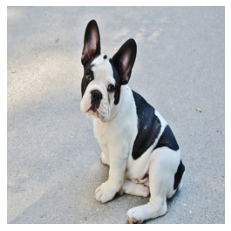

In [28]:
download_and_predict("https://cdn.pixabay.com/photo/2014/02/28/22/45/french-bulldog-277255_960_720.jpg",
         '/content/pic.jpg')

'n02109961-eskimo_dog'

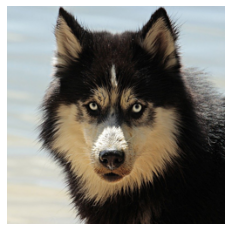

In [32]:
download_and_predict("https://cdn.pixabay.com/photo/2018/05/07/10/48/husky-3380548_960_720.jpg",
                     '/content/pic2.jpg')

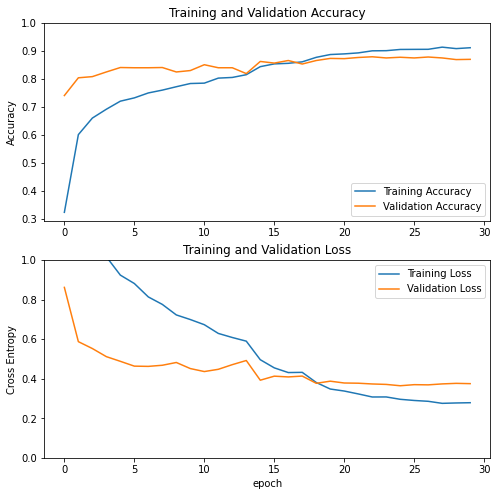

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()